In [1]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB

In [2]:
cities = {
    "Seattle": (47.6062, -122.3321),
    "San Francisco": (37.7749, -122.4194),
    "Los Angeles": (34.0522, -118.2437),
    "Phoenix": (33.4484, -112.0740),
    "Denver": (39.7392, -104.9903),
    "Dallas": (32.7767, -96.7970),
    "Chicago": (41.8781, -87.6298),
    "Nashville": (36.1627, -86.7816),
    "Atlanta": (33.7490, -84.3880),
    "Miami": (25.7617, -80.1918),
    "Washington D.C.": (38.9072, -77.0369),
    "New York": (40.7128, -74.0060),
    "Boston": (42.3601, -71.0589)
}

In [3]:
# Randomly generating flows between cities
W_ij = np.random.randint(1, 101, (13, 13))

# Initializing a matrix to store transportation costs
C_ij = np.zeros((13, 13))

# Function to compute Euclidean distance
def compute_distance(coord1, coord2):
    return np.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

# Assign transportation costs based on distances
for idx1, city1 in enumerate(cities):
    for idx2, city2 in enumerate(cities):
        distance = compute_distance(cities[city1], cities[city2])
        # Assuming $10 per unit distance for transportation cost
        C_ij[idx1, idx2] = distance * 10


In [4]:
# Assuming hub construction costs ranging between $100M to $500M
f_k = {city: np.random.randint(100, 501) for city in cities}

#there's a 20% discount on trunk transport between hubs.
alpha = 0.8

In [5]:
# Given Data
I = list(range(13))  # Set of nodes, considering 13 cities
P = 4  # Number of hubs

# Model Initialization
m = gp.Model("HubAndSpoke")

# Decision Variables
Y_ik = m.addVars(I, I, vtype=GRB.BINARY, name="Y_ik")
Y_kk = m.addVars(I, vtype=GRB.BINARY, name="Y_kk")

# Objective Function
obj = gp.quicksum(W_ij[i][j] * (C_ij[i][k] * Y_ik[i,k] + alpha * C_ij[k][l] * Y_ik[k,l] + C_ij[l][j] * Y_ik[l,j]) for i in I for j in I for k in I for l in I) + gp.quicksum(f_k[city] * Y_kk[k] for city, k in zip(cities, I))
m.setObjective(obj, GRB.MINIMIZE)

# Constraints
# Constraint 1: Each non-hub node can only be assigned to 1 hub node
for i in I:
    m.addConstr(gp.quicksum(Y_ik[i,k] for k in I) == 1)

# Constraint 2: Limit the number of hub nodes to P
m.addConstr(gp.quicksum(Y_kk[k] for k in I) == P)

# Constraint 3: We cannot assign a non-hub node to a hub node unless we open it
for i in I:
    for k in I:
        m.addConstr(Y_ik[i,k] <= Y_kk[k])

# Solve Model
m.optimize()


Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-26
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: AMD Ryzen 7 5825U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 183 rows, 182 columns and 520 nonzeros
Model fingerprint: 0xabd3bbc1
Variable types: 0 continuous, 182 integer (182 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 1e+07]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 6.632725e+07
Presolve time: 0.01s
Presolved: 183 rows, 182 columns, 520 nonzeros
Variable types: 0 continuous, 182 integer (182 binary)
Found heuristic solution: objective 2.067875e+07

Root relaxation: objective 1.598267e+07, 60 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work


In [6]:
# Print Results
if m.status == GRB.OPTIMAL:
    print('Optimal Objective Value: ', m.objVal)
    hubs = [k for k in I if Y_kk[k].x > 0.5]
    print('Optimal Hub Locations (indexes): ', hubs)
    assignments = {(i,k): Y_ik[i,k].x for i in I for k in I if Y_ik[i,k].x > 0.5}
    print('Assignments: ', assignments)

Optimal Objective Value:  15982669.933119074
Optimal Hub Locations (indexes):  [0, 3, 7, 11]
Assignments:  {(0, 0): 1.0, (1, 0): 1.0, (2, 3): 1.0, (3, 3): 1.0, (4, 3): 1.0, (5, 7): 1.0, (6, 7): 1.0, (7, 7): 1.0, (8, 7): 1.0, (9, 7): 1.0, (10, 11): 1.0, (11, 11): 1.0, (12, 11): 1.0}


In [ ]:
# Results can be changed as we used random numbers

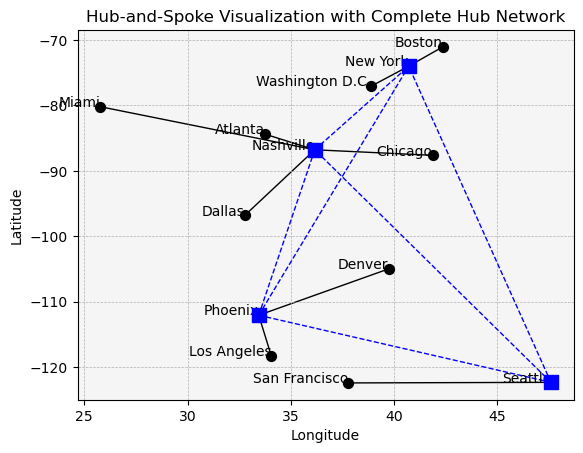

<Figure size 640x480 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt

# Extract Results
hubs = [k for k in I if Y_kk[k].x > 0.5]
assignments = {(i,k): Y_ik[i,k].x for i in I for k in I if Y_ik[i,k].x > 0.5}

# Plot Cities and Hubs
for idx, city in enumerate(cities):
    if idx in hubs:
        plt.scatter(cities[city][0], cities[city][1], color='blue', s=100, zorder=5, marker='s')
        plt.text(cities[city][0], cities[city][1], city, fontsize=10, ha='right')
    else:
        plt.scatter(cities[city][0], cities[city][1], color='black', s=50, zorder=5)
        plt.text(cities[city][0], cities[city][1], city, fontsize=10, ha='right')

# Draw Assignments
for (i, k), v in assignments.items():
    if v > 0.5:
        city_i = list(cities.keys())[i]
        city_k = list(cities.keys())[k]
        plt.plot([cities[city_i][0], cities[city_k][0]], [cities[city_i][1], cities[city_k][1]], 'k-', lw=1, zorder=1)

# Create Complete Graph Among Hubs
for idx1, hub1 in enumerate(hubs):
    for idx2, hub2 in enumerate(hubs):
        if idx1 < idx2:
            city1 = list(cities.keys())[hub1]
            city2 = list(cities.keys())[hub2]
            plt.plot([cities[city1][0], cities[city2][0]], [cities[city1][1], cities[city2][1]], 'b--', lw=1, zorder=2)

plt.title("Hub-and-Spoke Visualization with Complete Hub Network")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().set_facecolor('whitesmoke')
plt.show()
plt.savefig("hub_and_spoke_visualization.png", dpi=300)  

In [34]:
import folium

# Initial map centered around the United States
m = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

# Plot hubs (in blue) and non-hubs (in black)
for idx, city in enumerate(cities):
    if idx in hubs:
        folium.Marker(
            location=cities[city],
            icon=folium.Icon(color='blue', icon='cloud'),
            popup=city
        ).add_to(m)
    else:
        folium.Marker(
            location=cities[city],
            popup=city
        ).add_to(m)

# Draw lines connecting non-hubs to their hubs
for (i, k), v in assignments.items():
    if v > 0.5:
        city_i = list(cities.keys())[i]
        city_k = list(cities.keys())[k]
        folium.PolyLine([cities[city_i], cities[city_k]], color="black").add_to(m)

# Create lines to represent the complete graph among hubs
for idx1, hub1 in enumerate(hubs):
    for idx2, hub2 in enumerate(hubs):
        if idx1 < idx2:
            city1 = list(cities.keys())[hub1]
            city2 = list(cities.keys())[hub2]
            folium.PolyLine([cities[city1], cities[city2]], color="blue", dash_array="5, 5").add_to(m)




In [35]:
# Display the map
m